In [ ]:
# default_exp nbeats.learner

In [ ]:
# hide
import sys

sys.path.append("..")
import pandas as pd
%load_ext autoreload
%autoreload 2

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# N-Beats Learner

> A basic architecture for time series forecasting.


The approach is based on https://arxiv.org/abs/1905.10437


In [ ]:
# hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#export
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.callback.hook import num_features_model
from fastai2.callback.all import *
from fastai2.torch_core import *
from torch.autograd import Variable
from fastseq.all import *

from fastseq.nbeats.metrics import *
from fastseq.nbeats.model import *

## Learner

In [ ]:
# export
# from fastai2.basics import *
# from fastseq.all import *

@delegates(NBeatsNet.__init__)
def nbeats_learner(dbunch:TSDataLoaders, output_channels=None, metrics=None,cbs=None, theta=0., b_loss=0., loss_func=None, **kwargs):
    "Build a N-Beats style learner"    
    model = NBeatsNet(
        device = dbunch.train.device,
        horizon = dbunch.train.horizon,
        lookback = dbunch.train.lookback, 
        **kwargs
       )
    
    loss_func = ifnone(loss_func, F.mse_loss)
    learn = Learner(dbunch, model, loss_func=loss_func, opt_func= Adam, 
                    metrics=L(metrics)+L(mae, smape,NBeatsBackwards()),
                    cbs=L(NBeatsTrainer(),NBeatsAttention())+L(cbs)
                   )
    learn.lh = (dbunch.train.lookback/dbunch.train.horizon)
    return learn

# Example

In [ ]:
from fastseq.data.external import *
items = dummy_data_generator(50, 10, nrows=100)
data = TSDataLoaders.from_items(items, horizon = 5,lookback = 15)

learn = nbeats_learner(data)

learn.fit(10,.1)
learn.recorder.plot_loss()

Train:1600; Valid: 1600; Test 100


epoch,train_loss,valid_loss,mae,smape,b_loss,time
0,11.973428,2.077379,1.164959,0.333215,97.443138,00:02


../fastseq/nbeats/metrics.py:50: UserWarning: Using a target size (torch.Size([64, 1, 15])) that is different to the input size (torch.Size([128, 1, 15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value = learn.loss_func(b.float(), *learn.xb, reduction='mean')


RuntimeError: The size of tensor a (128) must match the size of tensor b (64) at non-singleton dimension 0

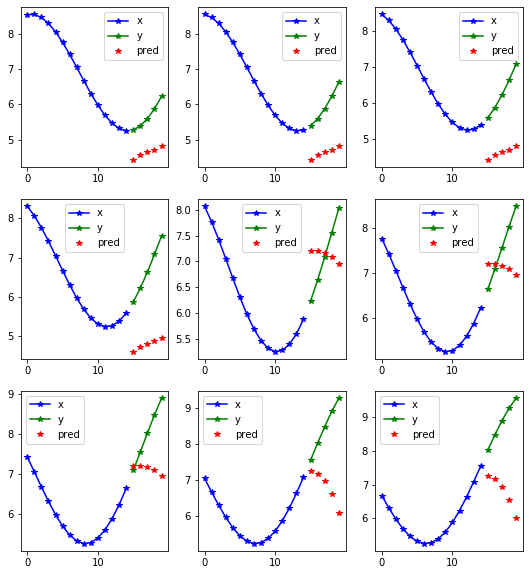

In [ ]:
learn.show_results(0)

In [ ]:
learn.n_beats_attention.means()

,trend0_0,trend0_1,trend0_2,seaonality1_0,seaonality1_1,seaonality1_2
theta_0_mean,0.051486067,0.056249738,0.028125005,-0.55918777,-0.2024852,-0.43757272
theta_0_std,0.049453083,0.049999785,0.04531635,0.4974187,0.7373811,0.4999357
theta_1_mean,0.051486067,0.056249738,0.028125005,0.55918777,-0.5781956,-0.43757272
theta_1_std,0.049453083,0.049999785,0.04531635,0.4974187,0.49767995,0.4999357
theta_2_mean,0.051486067,0.037297808,0.028125005,-0.55918777,-0.5781956,0.43757272
theta_2_std,0.049453083,0.06493338,0.04531635,0.4974187,0.49767995,0.4999357
att_mean,0.526777,0.562499,0.281266,0.562213,0.57918,0.438566
att_std,0.487203,0.496077,0.449599,0.493056,0.492693,0.49521


In [ ]:
# hide
print(learn.summary())

NBeatsNet (Input shape: ['64 x 1 x 20'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 20              40         True      
________________________________________________________________
Linear               64 x 200             4,000      True      
________________________________________________________________
ReLU                 64 x 200             0          False     
________________________________________________________________
BatchNorm1d          64 x 200             400        True      
________________________________________________________________
Linear               64 x 100             20,000     True      
________________________________________________________________
BatchNorm1d          64 x 100             200        True      
________________________________________________________________
Linear               64 x 1               100        True      
_________________________________________________________